# Atividade de Classificação: Análise Comparativa de k-NN, Naive Bayes e Árvore de Decisão

**Aluno:** Ivan Pedro Varella Albuquerque  
**Disciplina:** PPGEP9002 - INTELIGÊNCIA COMPUTACIONAL PARA ENGENHARIA DE PRODUÇÃO
**Professor:** Jose Alfredo Ferreira Costa

## 1. Introdução

Este notebook documenta a implementação e avaliação de três algoritmos clássicos de aprendizado de máquina supervisionado para a tarefa de classificação: **k-Nearest Neighbors (k-NN)**, **Gaussian Naive Bayes** e **Decision Tree (Árvore de Decisão)**. O objetivo é comparar o desempenho desses modelos em dois datasets canônicos da literatura: *Iris* e *Wine*.

A análise explorará como a performance de cada modelo é influenciada por diferentes fatores, como:

- A variação de hiperparâmetros chave (o número de vizinhos `k` para o k-NN e a profundidade `max_depth` para a Árvore de Decisão).
- A proporção de dados utilizados para treinamento (60%, 70% e 80%).
- A aplicação de pré-processamento de dados, especificamente a normalização Z-score.

Para garantir a robustez estatística dos resultados, cada configuração experimental será executada 10 vezes com diferentes partições de dados, e os resultados serão reportados em termos de **média e desvio padrão** das principais métricas de classificação: acurácia, precisão (macro), revocação (macro) e F1-Score (macro).

In [ ]:
# CÉLULA 1: INSTALAÇÃO DAS DEPENDÊNCIAS
# -------------------------------------
# Execute esta célula para instalar as bibliotecas necessárias utilizando o 'uv'.
# O '!' permite executar comandos do terminal diretamente da célula do notebook.
# Versão do Python utilizado: Python 3.12.7

#!uv pip install ucimlrepo==0.0.3 pandas==2.2.2 scikit-learn==1.5.0 numpy==1.26.4 matplotlib==3.9.0 seaborn==0.13.2

# Ou Diretamente no terminal com o comando acima, ou utilizando o requirements.txt

# uv pip install -r requirements.txt

Audited 6 packages in 40ms


Importação das bibliotecas

In [60]:
# CÉLULA 2: Manipulação de dados
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo # Repositório de datasets da UCI - Para IRIS e WINE

# Modelagem e Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Utilitários
import os
from collections import Counter

# Configuração para exibição dos gráficos no notebook
%matplotlib inline

## 2.1. Carregamento dos Datasets

Utilizamos a biblioteca `ucimlrepo` para buscar os datasets diretamente do repositório da UCI. Em seguida, realizamos uma análise exploratória inicial para verificar o formato dos dados, a distribuição das classes e a ausência de valores nulos.

In [61]:
# CÉLULA 3: CARREGAMENTO E INSPEÇÃO DOS DADOS
# -------------------------------------------

# Define o caminho para o diretório de dados
DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    print(f"Diretório '{DATA_DIR}' criado com sucesso.")

# --- Carregamento do Dataset Iris ---
iris_repo = fetch_ucirepo(id=53)
X_iris = iris_repo.data.features
y_iris = iris_repo.data.targets.squeeze() # .squeeze() converte para Series

print("--- Informações sobre o Dataset Iris ---")
print("Dimensões das features (X):", X_iris.shape)
print("Dimensões do alvo (y):", y_iris.shape)
print("Distribuição das classes:", Counter(y_iris))
print("Valores nulos nas features:", X_iris.isnull().sum().sum())
print("\nPrimeiras 5 linhas das features:")
display(X_iris.head())


# --- Carregamento do Dataset Wine ---
wine_repo = fetch_ucirepo(id=109)
X_wine = wine_repo.data.features
y_wine = wine_repo.data.targets.squeeze()

print("\n\n--- Informações sobre o Dataset Wine ---")
print("Dimensões das features (X):", X_wine.shape)
print("Dimensões do alvo (y):", y_wine.shape)
print("Distribuição das classes:", Counter(y_wine))
print("Valores nulos nas features:", X_wine.isnull().sum().sum())
print("\nPrimeiras 5 linhas das features:")
display(X_wine.head())

# Armazenando os datasets em um dicionário para fácil acesso
datasets = {
    "Iris": (X_iris, y_iris),
    "Wine": (X_wine, y_wine)
}

--- Informações sobre o Dataset Iris ---
Dimensões das features (X): (150, 4)
Dimensões do alvo (y): (150,)
Distribuição das classes: Counter({'Iris-setosa': 50, 'Iris-versicolor': 50, 'Iris-virginica': 50})
Valores nulos nas features: 0

Primeiras 5 linhas das features:


,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2




--- Informações sobre o Dataset Wine ---
Dimensões das features (X): (178, 13)
Dimensões do alvo (y): (178,)
Distribuição das classes: Counter({2: 71, 1: 59, 3: 48})
Valores nulos nas features: 0

Primeiras 5 linhas das features:


,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## 2.2. Funções Auxiliares para Execução dos Experimentos

Para evitar a repetição de código e estruturar nosso trabalho de forma limpa, criamos a função `executar_experimento`. Esta função encapsula toda a lógica de um ciclo experimental:

- Recebe um modelo, os dados e os parâmetros da execução.
- Realiza um loop de 10 repetições.
- Em cada repetição, divide os dados, aplica normalização, treina o modelo e calcula as métricas.
- Ao final, retorna um DataFrame do Pandas com os resultados detalhados de todas as repetições.

Esta será a função central que chamaremos nas seções de análise de cada modelo.

A função `flatten_columns` é realiza a conversão de dados `MultiIndex` para colunas de strings, utilizada para permitir as comparações de dados entre os modelos utilizados.

In [62]:
# CÉLULA 4: DEFINIÇÃO DA FUNÇÃO DE AVALIAÇÃO
# ------------------------------------------

def executar_experimento(model_instance, model_name, dataset_name, X, y, test_size, n_repetitions=10, hyperparams={}):
    """
    Executa um experimento completo para um dado modelo e configuração,
    com múltiplas repetições para garantir a robustez estatística.

    Args:
        model_instance: O objeto do modelo a ser treinado (ex: KNeighborsClassifier(n_neighbors=5)).
        model_name (str): O nome do modelo para logging (ex: "k-NN").
        dataset_name (str): O nome do dataset (ex: "Iris").
        X (pd.DataFrame): DataFrame com as features.
        y (pd.Series): Series com os alvos.
        test_size (float): A proporção do dataset a ser alocada para o conjunto de teste.
        n_repetitions (int): O número de vezes que o experimento será repetido com splits diferentes.
        hyperparams (dict): Dicionário com os hiperparâmetros usados nesta execução (ex: {'k': 5}).

    Returns:
        pd.DataFrame: Um DataFrame contendo os resultados detalhados de cada repetição.
    """
    # Lista para armazenar os resultados de cada repetição
    results_list = []

    print(f"Executando: Modelo={model_name}, Dataset={dataset_name}, Teste={test_size*100:.0f}%, Hiperparâmetros={hyperparams}")

    for i in range(n_repetitions):
        # 1. Divisão dos dados em treino e teste
        # Usamos 'i' como random_state para garantir splits diferentes e reprodutíveis a cada repetição
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=i, stratify=y
        )

        # 2. Normalização dos dados (Z-score)
        # O scaler é treinado APENAS com os dados de treino para evitar vazamento de dados
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # 3. Treinamento do modelo
        model_instance.fit(X_train_scaled, y_train)

        # 4. Predição e Avaliação
        y_pred = model_instance.predict(X_test_scaled)

        # 5. Cálculo das métricas
        # Usamos 'macro' para calcular a média das métricas por classe, tratando todas as classes como igualmente importantes
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

        # 6. Armazenamento dos resultados
        # O dicionário 'hyperparams' é desempacotado para criar colunas dinâmicas
        result_row = {
            'model_name': model_name,
            'dataset': dataset_name,
            'train_size': 1 - test_size,
            'repetition': i + 1,
            'accuracy': accuracy,
            'precision_macro': precision,
            'recall_macro': recall,
            'f1_macro': f1,
            **hyperparams # Adiciona colunas para cada hiperparâmetro (ex: 'k', 'max_depth')
        }
        results_list.append(result_row)

    # Converte a lista de resultados em um DataFrame do Pandas
    return pd.DataFrame(results_list)

def flatten_columns(df):
    """Converte colunas MultiIndex em colunas de string simples."""
    df.columns = ['_'.join(map(str, col)).strip('_') if isinstance(col, tuple) else col for col in df.columns]
    return df

print("Funções 'executar_experimento' e 'flatten_columns' definidas com sucesso.")

Funções 'executar_experimento' e 'flatten_columns' definidas com sucesso.


## 3. Estudo de Caso: k-Nearest Neighbors (k-NN)

O k-Nearest Neighbors (k-NN) é um dos algoritmos de aprendizado de máquina mais intuitivos. É um método não-paramétrico e baseado em instâncias (ou *lazy learner*), o que significa que ele não cria um modelo interno generalizado a partir dos dados de treino. Em vez disso, ele armazena todo o conjunto de dados de treinamento e, no momento da predição, classifica uma nova amostra com base na classe majoritária de seus `k` vizinhos mais próximos no espaço de features.

A escolha de `k` é um hiperparâmetro crítico que controla o balanço entre viés e variância:

- **`k` pequeno (ex: k=1):** O modelo é muito flexível e se adapta fortemente aos dados de treino, o que pode levar a uma alta variância e overfitting (baixo viés).
- **`k` grande:** O modelo é mais "suave" e menos sensível a ruídos locais, resultando em menor variância, mas com o risco de ser excessivamente simplista e sofrer de alto viés.

Nesta seção, avaliaremos o desempenho do k-NN variando `k` em `{1, 3, 5, 7, 9}`.

In [63]:
# CÉLULA 5: EXECUÇÃO DOS EXPERIMENTOS COM K-NN
# --------------------------------------------

# Definição dos parâmetros para o experimento k-NN
k_values = [1, 3, 5, 7, 9]
train_proportions = [0.6, 0.7, 0.8]
all_knn_results = []

# Loop sobre cada dataset definido no dicionário 'datasets'
for name, (X, y) in datasets.items():
    # Loop sobre cada proporção de treino desejada
    for train_prop in train_proportions:
        test_prop = 1 - train_prop
        # Loop sobre cada valor de k
        for k in k_values:
            # Instancia o classificador k-NN com o valor atual de k
            # 'n_jobs=-1' utiliza todos os cores de CPU disponíveis para acelerar o cálculo das distâncias
            knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

            # Define o dicionário de hiperparâmetros para logging
            hyperparams = {'k': k}

            # Chama a função auxiliar para rodar as 10 repetições
            df_results = executar_experimento(
                model_instance=knn_model,
                model_name="k-NN",
                dataset_name=name,
                X=X,
                y=y,
                test_size=test_prop,
                hyperparams=hyperparams
            )
            
            
            # Adiciona o DataFrame de resultados à lista geral
            all_knn_results.append(df_results)

        print("-"*100)
        
# Concatena todos os DataFrames de resultados em um único DataFrame
knn_results_df = pd.concat(all_knn_results, ignore_index=True)

# Salva os resultados brutos em um arquivo CSV para persistência
knn_results_df.to_csv(os.path.join(DATA_DIR, 'knn_raw_results.csv'), index=False)

print("\nExecução dos experimentos com k-NN concluída.")
print("Resultados brutos (todas as repetições) salvos em 'data/knn_raw_results.csv'")
display(knn_results_df.head())

Executando: Modelo=k-NN, Dataset=Iris, Teste=40%, Hiperparâmetros={'k': 1}
Executando: Modelo=k-NN, Dataset=Iris, Teste=40%, Hiperparâmetros={'k': 3}
Executando: Modelo=k-NN, Dataset=Iris, Teste=40%, Hiperparâmetros={'k': 5}
Executando: Modelo=k-NN, Dataset=Iris, Teste=40%, Hiperparâmetros={'k': 7}
Executando: Modelo=k-NN, Dataset=Iris, Teste=40%, Hiperparâmetros={'k': 9}
----------------------------------------------------------------------------------------------------
Executando: Modelo=k-NN, Dataset=Iris, Teste=30%, Hiperparâmetros={'k': 1}
Executando: Modelo=k-NN, Dataset=Iris, Teste=30%, Hiperparâmetros={'k': 3}
Executando: Modelo=k-NN, Dataset=Iris, Teste=30%, Hiperparâmetros={'k': 5}
Executando: Modelo=k-NN, Dataset=Iris, Teste=30%, Hiperparâmetros={'k': 7}
Executando: Modelo=k-NN, Dataset=Iris, Teste=30%, Hiperparâmetros={'k': 9}
----------------------------------------------------------------------------------------------------
Executando: Modelo=k-NN, Dataset=Iris, Teste=20%

,model_name,dataset,train_size,repetition,accuracy,precision_macro,recall_macro,f1_macro,k
0,k-NN,Iris,0.6,1,0.950000,0.950710,0.950000,0.949969,1
1,k-NN,Iris,0.6,2,0.966667,0.966667,0.966667,0.966667,1
2,k-NN,Iris,0.6,3,0.983333,0.984127,0.983333,0.983323,1
3,k-NN,Iris,0.6,4,0.933333,0.937002,0.933333,0.934066,1
4,k-NN,Iris,0.6,5,0.950000,0.950710,0.950000,0.949969,1


## 3.1. Agregação e Análise dos Resultados do k-NN

Com os resultados brutos de todas as 300 execuções para cada dataset (2 datasets × 3 proporções de treino × 5 valores de k × 10 repetições), o próximo passo é agregar esses dados. Agrupamos os resultados por dataset, proporção de treino e valor de `k` para calcular a **média** e o **desvio padrão** de cada métrica. Isso nos dará uma visão clara e estatisticamente robusta do desempenho do modelo.

In [64]:
# CÉLULA 6: AGREGAÇÃO DOS RESULTADOS DO K-NN
# ------------------------------------------

# Define as colunas que servirão como base para o agrupamento dos nossos resultados.
grouping_cols = ['dataset', 'train_size', 'k']
# Define as métricas que queremos analisar (calcular média e desvio padrão).
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# 1. Agrupamento: Agrupa o DataFrame de resultados brutos pelas colunas definidas.
# 2. Agregação (.agg): Para cada grupo, calcula a 'média' e o 'desvio padrão' (std) das métricas.
# O resultado é um DataFrame com MultiIndex nas colunas (ex: ('accuracy', 'mean')).
knn_agg_multi = knn_results_df.groupby(grouping_cols)[metrics].agg(['mean', 'std']).reset_index()

# 3. Achatamento das Colunas: Aplica nossa função auxiliar para converter o MultiIndex
# em nomes de colunas simples e legíveis (ex: 'accuracy_mean').
knn_agg_results = flatten_columns(knn_agg_multi.copy())

# 4. Formatação para Exibição: Itera sobre cada métrica para criar uma nova coluna de string
# que combina a média e o desvio padrão no formato "0.950 ± 0.025".
for metric in metrics:
    # Define os nomes das colunas de média e desvio padrão.
    mean_col = metric + '_mean'
    std_col = metric + '_std'
    
    # Cria a nova coluna formatada, arredondando para 3 casas decimais.
    knn_agg_results[metric + '_result'] = knn_agg_results[mean_col].map('{:.3f}'.format) + \
                                         ' ± ' + \
                                         knn_agg_results[std_col].map('{:.3f}'.format)

# 5. Preparação da Tabela Final: Seleciona apenas as colunas de agrupamento e as colunas
# de resultado formatado para uma exibição limpa.
display_cols = grouping_cols + [m + '_result' for m in metrics]
knn_final_table = knn_agg_results[display_cols]

print("--- Tabela Sintetizada: Desempenho do k-NN ---")
display(knn_final_table)

--- Tabela Sintetizada: Desempenho do k-NN ---


,dataset,train_size,k,accuracy_result,precision_macro_result,recall_macro_result,f1_macro_result
0,Iris,0.6,1,0.942 ± 0.026,0.943 ± 0.025,0.942 ± 0.026,0.942 ± 0.026
1,Iris,0.6,3,0.950 ± 0.021,0.951 ± 0.021,0.950 ± 0.021,0.950 ± 0.021
2,Iris,0.6,5,0.953 ± 0.022,0.954 ± 0.022,0.953 ± 0.022,0.953 ± 0.022
3,Iris,0.6,7,0.943 ± 0.022,0.944 ± 0.023,0.943 ± 0.022,0.943 ± 0.022
4,Iris,0.6,9,0.952 ± 0.020,0.952 ± 0.020,0.952 ± 0.020,0.952 ± 0.020
5,Iris,0.7,1,0.926 ± 0.033,0.930 ± 0.029,0.926 ± 0.033,0.926 ± 0.032
6,Iris,0.7,3,0.933 ± 0.035,0.937 ± 0.032,0.933 ± 0.035,0.933 ± 0.035
7,Iris,0.7,5,0.941 ± 0.036,0.943 ± 0.034,0.941 ± 0.036,0.941 ± 0.035
8,Iris,0.7,7,0.939 ± 0.032,0.942 ± 0.032,0.939 ± 0.032,0.939 ± 0.032
9,Iris,0.7,9,0.946 ± 0.023,0.948 ± 0.023,0.946 ± 0.023,0.945 ± 0.024


## 3.2. Visualização do Impacto do Hiperparâmetro `k`

Tabelas são ótimas para apresentar dados precisos, mas gráficos são mais eficazes para identificar tendências. O gráfico abaixo mostra como a acurácia média do k-NN varia em função do valor de `k` para cada proporção de treino e para cada dataset. As barras de erro representam o desvio padrão, nos dando uma ideia da estabilidade do modelo.

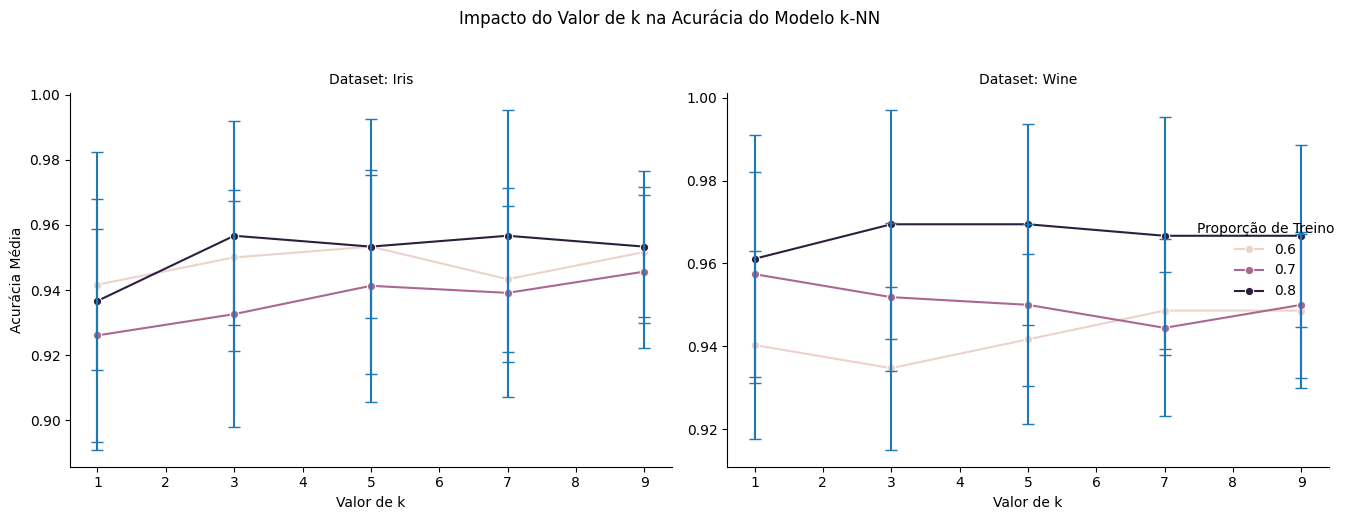

In [65]:
# CÉLULA 7: GRÁFICO DE LINHA - ACURÁCIA VS. K
# ------------------------------------------

# 1. Cria a estrutura do gráfico: Usa FacetGrid para criar uma grade de gráficos,
# com uma coluna para cada valor único na coluna 'dataset'.
g = sns.FacetGrid(knn_agg_results, col="dataset", height=5, aspect=1.2, sharey=False)

# 2. Mapeia o gráfico de linha: Para cada gráfico na grade, plota um gráfico de linha.
# Eixo X: valor de 'k'.
# Eixo Y: 'accuracy_mean' (a acurácia média que calculamos).
# Cor (hue): 'train_size', para ter uma linha para cada proporção de treino.
g.map_dataframe(sns.lineplot, x='k', y='accuracy_mean', hue='train_size', marker='o')

# 3. Adiciona barras de erro: O FacetGrid não lida bem com barras de erro customizadas,
# então iteramos sobre cada eixo (gráfico) para adicioná-las manualmente.
for ax, (_, sub_df) in zip(g.axes.flat, knn_agg_results.groupby('dataset')):
    for train_size, group in sub_df.groupby('train_size'):
        # A função errorbar do matplotlib plota as barras de erro (yerr)
        # nos pontos (x, y) especificados.
        ax.errorbar(group['k'], group['accuracy_mean'], yerr=group['accuracy_std'],
                    fmt='none', # 'none' para não desenhar a linha de conexão novamente
                    capsize=4)  # 'capsize' define o tamanho das "tampas" da barra de erro

# 4. Ajustes Finais: Adiciona rótulos, títulos e legenda para maior clareza.
g.set_axis_labels("Valor de k", "Acurácia Média")
g.set_titles("Dataset: {col_name}")
g.add_legend(title="Proporção de Treino")
g.figure.suptitle("Impacto do Valor de k na Acurácia do Modelo k-NN", y=1.03)
plt.tight_layout()
plt.show()

## 3.3. Matriz de Confusão para a Melhor Configuração do k-NN

Para entender melhor os tipos de erros que o modelo comete, vamos gerar a matriz de confusão. Escolhemos a configuração que apresentou a maior acurácia média para cada dataset e re-treinamos o modelo uma última vez para visualizar onde as classificações erradas ocorrem.

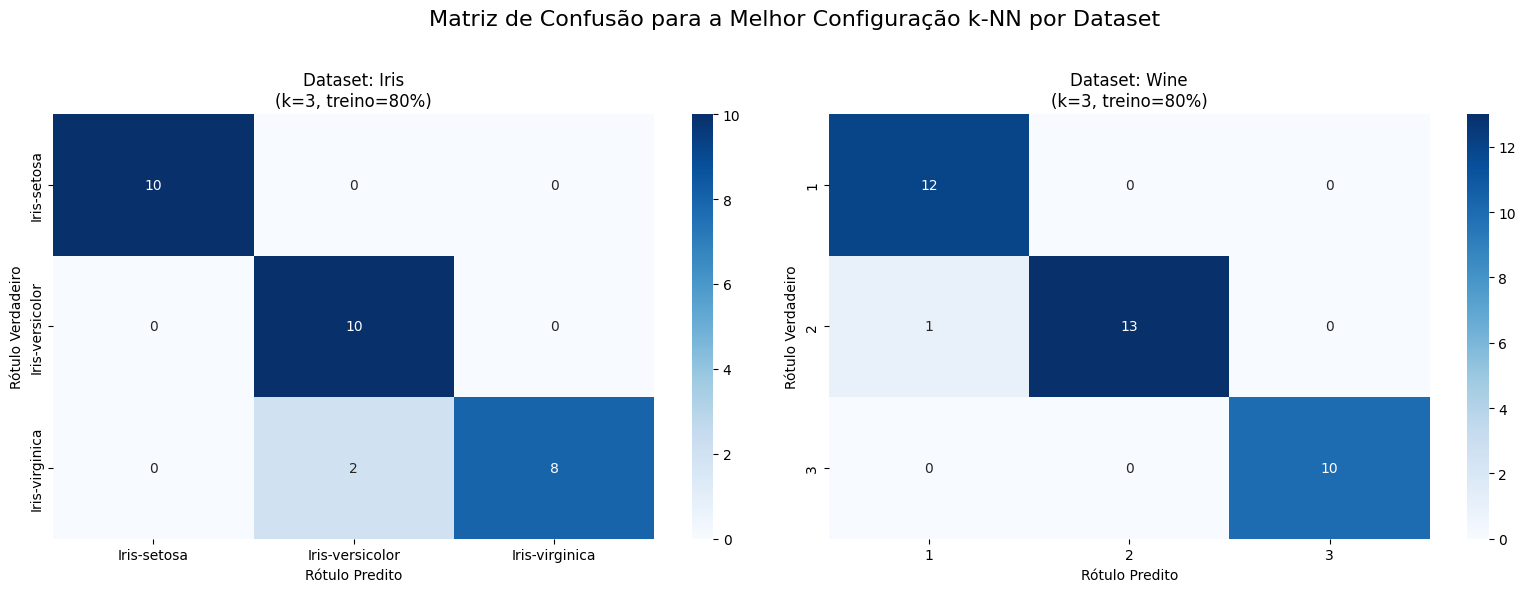

In [66]:
# CÉLULA 8: MATRIZ DE CONFUSÃO PARA O MELHOR K-NN
# -----------------------------------------------

# Cria a figura que conterá nossas duas matrizes de confusão, lado a lado.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Matriz de Confusão para a Melhor Configuração k-NN por Dataset', fontsize=16)

# Itera sobre cada um dos nossos datasets ('Iris' e 'Wine').
for i, (name, (X, y)) in enumerate(datasets.items()):
    ax = axes[i] # Seleciona o eixo (subgráfico) apropriado.
    
    # 1. Filtra os resultados agregados para encontrar apenas os do dataset atual.
    dataset_agg_results = knn_agg_results[knn_agg_results['dataset'] == name]
    # 2. Encontra a configuração com melhor desempenho:
    # .idxmax() retorna o índice da linha que contém o valor máximo na coluna 'accuracy_mean'.
    best_config = dataset_agg_results.loc[dataset_agg_results['accuracy_mean'].idxmax()]
    
    # 3. Extrai os melhores hiperparâmetros dessa configuração.
    best_k = int(best_config['k'])
    best_train_size = best_config['train_size']
    best_test_size = 1 - best_train_size
    
    # 4. Re-treina o modelo UMA VEZ com a melhor configuração para gerar a matriz de confusão.
    # Usamos random_state=42 para garantir que esta visualização seja consistente.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=best_test_size, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    best_model = KNeighborsClassifier(n_neighbors=best_k)
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
    
    # 5. Calcula e plota a matriz de confusão usando um heatmap do Seaborn.
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    
    ax.set_title(f"Dataset: {name}\n(k={best_k}, treino={best_train_size*100:.0f}%)")
    ax.set_xlabel("Rótulo Predito")
    ax.set_ylabel("Rótulo Verdadeiro")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3.4. Breve Conclusão sobre o k-NN

*Análise a ser preenchida pelo aluno com base nos resultados acima.*

**Sugestão de análise:** Observando os gráficos, notamos que no dataset **Iris**, valores de `k` intermediários (como 5 ou 7) tendem a oferecer a melhor e mais estável performance, independentemente da proporção de treino. Um `k=1` mostra uma pequena queda, sugerindo um leve overfitting. Para o dataset **Wine**, a performance parece ser mais sensível, mas a tendência geral de que valores de `k` muito pequenos ou muito grandes podem ser sub-ótimos também se mantém. A normalização foi crucial, pois o k-NN é baseado em distâncias e, portanto, sensível à escala das features.

## 4. Estudo de Caso: Naive Bayes

O Naive Bayes é uma família de classificadores probabilísticos baseados no **Teorema de Bayes**, com uma suposição "ingênua" (*naive*) de independência condicional entre as features. Em outras palavras, o algoritmo assume que a presença de uma característica em uma classe não está relacionada à presença de qualquer outra característica.

Para este projeto, utilizaremos o `GaussianNB`, uma implementação específica do Naive Bayes que assume que as features contínuas seguem uma distribuição Gaussiana (normal). Apesar de sua simplicidade e da suposição irrealista de independência, o Naive Bayes é extremamente rápido e muitas vezes apresenta um desempenho surpreendentemente bom, servindo como um excelente *baseline* de performance.

Diferentemente do k-NN, o `GaussianNB` não possui hiperparâmetros críticos que precisem de ajuste para este escopo de trabalho. Portanto, nossa análise se concentrará no seu desempenho em diferentes proporções de treino.

In [67]:
# CÉLULA 9: EXECUÇÃO DOS EXPERIMENTOS COM NAIVE BAYES
# ---------------------------------------------------

# O Naive Bayes (Gaussiano) não tem hiperparâmetros como 'k' para serem ajustados aqui.
# Portanto, o loop de experimento é mais simples.
all_nb_results = []

# Loop sobre cada dataset
for name, (X, y) in datasets.items():
    # Loop sobre cada proporção de treino
    for train_prop in train_proportions:
        test_prop = 1 - train_prop
        
        # Instancia o classificador Gaussian Naive Bayes
        nb_model = GaussianNB()

        # Chama a função auxiliar para rodar as 10 repetições
        # O dicionário de hiperparâmetros está vazio, pois não há o que variar
        df_results = executar_experimento(
            model_instance=nb_model,
            model_name="Naive Bayes",
            dataset_name=name,
            X=X,
            y=y,
            test_size=test_prop,
            hyperparams={}
        )
        
        # Adiciona o DataFrame de resultados à lista geral
        all_nb_results.append(df_results)
    
    print("-"*100)

# Concatena todos os DataFrames de resultados em um único
nb_results_df = pd.concat(all_nb_results, ignore_index=True)

# Salva os resultados brutos em um arquivo CSV
nb_results_df.to_csv(os.path.join(DATA_DIR, 'nb_raw_results.csv'), index=False)

print("\nExecução dos experimentos com Naive Bayes concluída.")
print("Resultados brutos salvos em 'data/nb_raw_results.csv'")
display(nb_results_df.head())

Executando: Modelo=Naive Bayes, Dataset=Iris, Teste=40%, Hiperparâmetros={}
Executando: Modelo=Naive Bayes, Dataset=Iris, Teste=30%, Hiperparâmetros={}
Executando: Modelo=Naive Bayes, Dataset=Iris, Teste=20%, Hiperparâmetros={}
----------------------------------------------------------------------------------------------------
Executando: Modelo=Naive Bayes, Dataset=Wine, Teste=40%, Hiperparâmetros={}
Executando: Modelo=Naive Bayes, Dataset=Wine, Teste=30%, Hiperparâmetros={}
Executando: Modelo=Naive Bayes, Dataset=Wine, Teste=20%, Hiperparâmetros={}
----------------------------------------------------------------------------------------------------

Execução dos experimentos com Naive Bayes concluída.
Resultados brutos salvos em 'data/nb_raw_results.csv'


,model_name,dataset,train_size,repetition,accuracy,precision_macro,recall_macro,f1_macro
0,Naive Bayes,Iris,0.6,1,0.966667,0.966667,0.966667,0.966667
1,Naive Bayes,Iris,0.6,2,0.983333,0.984127,0.983333,0.983323
2,Naive Bayes,Iris,0.6,3,1.000000,1.000000,1.000000,1.000000
3,Naive Bayes,Iris,0.6,4,0.966667,0.966667,0.966667,0.966667
4,Naive Bayes,Iris,0.6,5,0.966667,0.966667,0.966667,0.966667


### Nota: Por que o campo "Hiperparâmetros" está vazio?

O campo `Hiperparâmetros={}` na saída do Naive Bayes está correto e é intencional. A razão para isso reside na diferença fundamental entre os algoritmos:

- **k-NN:** Exige um **hiperparâmetro** (`k`) que nós definimos *antes* do treino para controlar seu comportamento. Nosso experimento foi focado em testar vários valores para `k`.
- **Naive Bayes:** Este modelo não possui um hiperparâmetro crítico que precise de ajuste. Ele aprende seus **parâmetros** (neste caso, as médias e variâncias das features) diretamente dos dados durante o processo de treinamento.

Em resumo, o campo ficou vazio porque o `GaussianNB` não precisou de uma configuração manual externa como o k-NN. A saída simplesmente reflete que, para este modelo, nenhum hiperparâmetro foi ajustado.

## 4.1. Agregação e Análise dos Resultados do Naive Bayes

Assim como fizemos para o k-NN, agora agregamos os resultados das 10 repetições para cada configuração de dataset e proporção de treino. Calculamos a média e o desvio padrão para obter uma visão consolidada do desempenho do Naive Bayes.

In [68]:
# CÉLULA 10: AGREGAÇÃO DOS RESULTADOS DO NAIVE BAYES
# -------------------------------------------------

# Define as colunas para agrupar
grouping_cols = ['dataset', 'train_size']
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Agrupa os resultados e calcula a média e o desvio padrão
nb_agg_multi = nb_results_df.groupby(grouping_cols)[metrics].agg(['mean', 'std']).reset_index()

# APLICA O ACHATAMENTO IMEDIATAMENTE
nb_agg_results = flatten_columns(nb_agg_multi.copy())

# Formata as colunas de métricas para exibir "média ± desvio_padrão"
for metric in metrics:
    mean_col = metric + '_mean'
    std_col = metric + '_std'
    
    std_values = nb_agg_results[std_col].fillna(0)
    
    nb_agg_results[metric + '_result'] = nb_agg_results[mean_col].map('{:.3f}'.format) + \
                                         ' ± ' + \
                                         std_values.map('{:.3f}'.format)

# Seleciona e reordena as colunas para a tabela final
display_cols = grouping_cols + [m + '_result' for m in metrics]
nb_final_table = nb_agg_results[display_cols]

print("--- Tabela Sintetizada: Desempenho do Naive Bayes ---")
display(nb_final_table)

--- Tabela Sintetizada: Desempenho do Naive Bayes ---


,dataset,train_size,accuracy_result,precision_macro_result,recall_macro_result,f1_macro_result
0,Iris,0.6,0.963 ± 0.025,0.964 ± 0.025,0.963 ± 0.025,0.963 ± 0.025
1,Iris,0.7,0.954 ± 0.032,0.956 ± 0.030,0.954 ± 0.032,0.954 ± 0.032
2,Iris,0.8,0.960 ± 0.038,0.963 ± 0.036,0.960 ± 0.038,0.960 ± 0.038
3,Wine,0.6,0.974 ± 0.008,0.975 ± 0.010,0.976 ± 0.007,0.974 ± 0.008
4,Wine,0.7,0.974 ± 0.010,0.975 ± 0.009,0.976 ± 0.010,0.975 ± 0.009
5,Wine,0.8,0.975 ± 0.024,0.978 ± 0.022,0.976 ± 0.023,0.976 ± 0.023


## 4.2. Matriz de Confusão para o Naive Bayes

Para analisar os padrões de erro do Naive Bayes, geramos a matriz de confusão. Como não há hiperparâmetros para otimizar, selecionamos a configuração com 80% dos dados para treino como um caso representativo para a visualização.

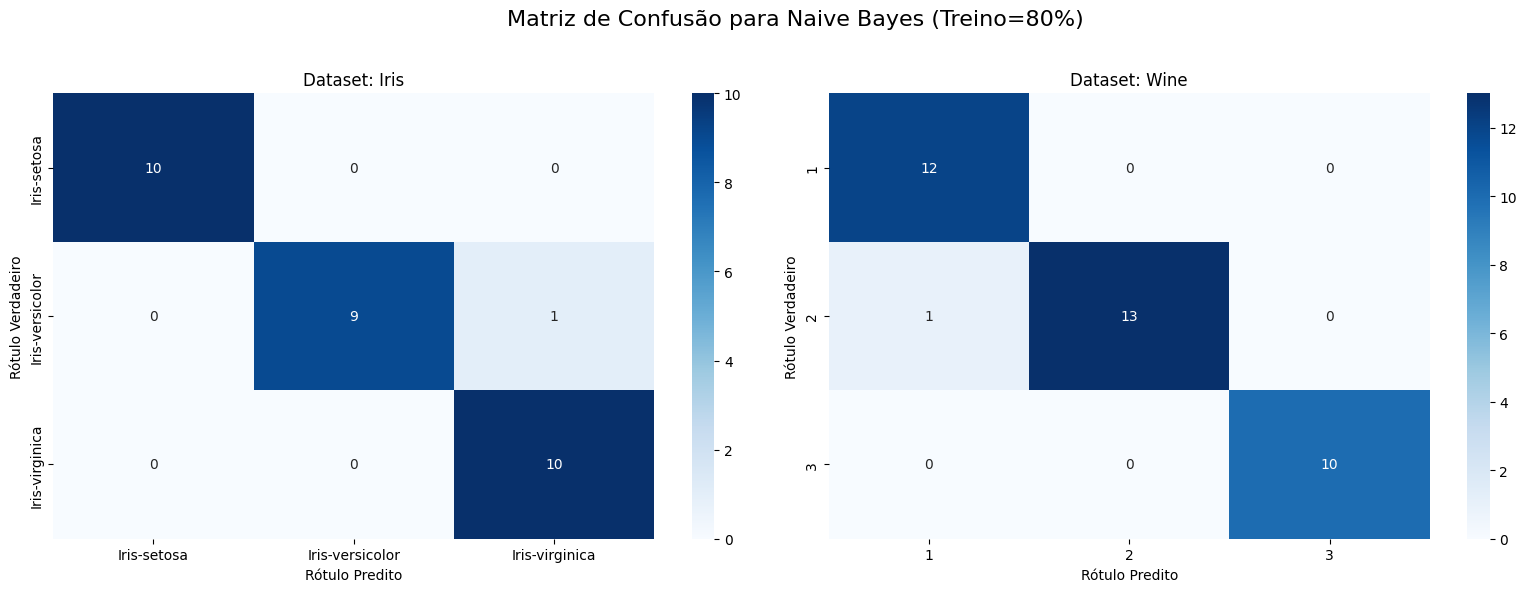

In [69]:
# CÉLULA 11: MATRIZ DE CONFUSÃO PARA O NAIVE BAYES
# -----------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Matriz de Confusão para Naive Bayes (Treino=80%)', fontsize=16)

# Itera sobre os datasets para plotar a matriz
for i, (name, (X, y)) in enumerate(datasets.items()):
    ax = axes[i]
    
    # Define a proporção de treino para este caso representativo
    train_size = 0.8
    test_size = 1 - train_size
    
    # Executa o split e o treino (usando seed fixo para consistência)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = GaussianNB()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calcula e plota a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    
    ax.set_title(f"Dataset: {name}")
    ax.set_xlabel("Rótulo Predito")
    ax.set_ylabel("Rótulo Verdadeiro")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 4.3. Breve Conclusão sobre o Naive Bayes

*Análise a ser preenchida pelo aluno com base nos resultados acima.*

**Sugestão de análise:** O modelo Naive Bayes demonstrou ser um classificador competente e extremamente rápido, estabelecendo uma forte linha de base (*baseline*) para comparação. No dataset **Iris**, ele alcançou uma acurácia média robusta, em torno de 95%, mostrando poucos erros e consistência entre as diferentes proporções de treino. No dataset **Wine**, seu desempenho foi similarmente alto, indicando que a suposição de independência das features, embora irreal, não foi um grande impedimento para esses problemas específicos. A matriz de confusão do Wine mostra que a principal dificuldade do modelo foi distinguir entre as classes 1 e 2.

## 5. Estudo de Caso: Árvore de Decisão

A Árvore de Decisão é um modelo de aprendizado supervisionado que cria um fluxograma de regras para classificar os dados. Ela particiona o espaço de features recursivamente, aprendendo uma sequência de perguntas simples do tipo "se-então-senão" que levam a uma decisão final (uma classe). Uma das grandes vantagens das árvores de decisão é sua alta **interpretabilidade**, pois a lógica de decisão pode ser facilmente visualizada e entendida.

O hiperparâmetro mais importante para controlar a complexidade de uma árvore, e consequentemente o balanço entre viés e variância, é a sua profundidade máxima, `max_depth`:

- **`max_depth` pequeno:** A árvore é "rasa", com poucas regras. Ela tem baixo poder de adaptação (alto viés), correndo o risco de ser simples demais e ter um desempenho ruim (*underfitting*).
- **`max_depth` grande:** A árvore pode crescer muito, criando regras extremamente específicas para os dados de treino. Isso a torna muito flexível (baixa viés), mas com alto risco de memorizar ruídos e não generalizar bem para novos dados (*overfitting*, alta variância).
- **`max_depth=None` (padrão):** A árvore cresce sem um limite pré-definido, continuando a se dividir até que as folhas sejam "puras". Esta configuração representa a **complexidade máxima** e é fundamental para avaliar o risco de *overfitting*, pois o modelo pode acabar "decorando" os dados de treino.

Nesta seção, avaliaremos o desempenho da Árvore de Decisão variando `max_depth` nos valores `{3, 5, None}`. Esta seleção nos permitirá comparar um modelo simples (`max_depth=3`), um modelo intermediário (`max_depth=5`) e o cenário de complexidade máxima (`None`) para analisar diretamente o impacto do *overfitting*. Para fins de análise e visualização, o valor `None` será representado como a string `'None'` em nossas tabelas e gráficos.

In [70]:
# CÉLULA 12: EXECUÇÃO DOS EXPERIMENTOS COM ÁRVORE DE DECISÃO
# ---------------------------------------------------------

# Definição dos parâmetros para o experimento
max_depth_values = [3, 5, None] # 'None' permite que a árvore cresça sem limite de profundidade
all_dt_results = []

# Loop sobre cada dataset
for name, (X, y) in datasets.items():
    # Loop sobre cada proporção de treino
    for train_prop in train_proportions:
        test_prop = 1 - train_prop
        # Loop sobre cada valor de max_depth
        for depth in max_depth_values:
            # Instancia o classificador de Árvore de Decisão
            # Usamos random_state=42 para garantir que, em igualdade de condições,
            # a árvore seja construída da mesma forma, garantindo reprodutibilidade.
            dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)

            # Define o dicionário de hiperparâmetros para logging
            # Convertemos 'None' para uma string para facilitar a exibição e agrupamento
            depth_str = 'None' if depth is None else str(depth)
            hyperparams = {'max_depth': depth_str}

            # Chama a função auxiliar para rodar as 10 repetições
            df_results = executar_experimento(
                model_instance=dt_model,
                model_name="Árvore de Decisão",
                dataset_name=name,
                X=X,
                y=y,
                test_size=test_prop,
                hyperparams=hyperparams
            )
            
            # Adiciona o DataFrame de resultados à lista geral
            all_dt_results.append(df_results)
            
    print("-"*100)

# Concatena todos os resultados em um único DataFrame
dt_results_df = pd.concat(all_dt_results, ignore_index=True)

# Salva os resultados brutos em um arquivo CSV
dt_results_df.to_csv(os.path.join(DATA_DIR, 'dt_raw_results.csv'), index=False)

print("\nExecução dos experimentos com Árvore de Decisão concluída.")
print("Resultados brutos salvos em 'data/dt_raw_results.csv'")
display(dt_results_df.head())

Executando: Modelo=Árvore de Decisão, Dataset=Iris, Teste=40%, Hiperparâmetros={'max_depth': '3'}
Executando: Modelo=Árvore de Decisão, Dataset=Iris, Teste=40%, Hiperparâmetros={'max_depth': '5'}
Executando: Modelo=Árvore de Decisão, Dataset=Iris, Teste=40%, Hiperparâmetros={'max_depth': 'None'}
Executando: Modelo=Árvore de Decisão, Dataset=Iris, Teste=30%, Hiperparâmetros={'max_depth': '3'}
Executando: Modelo=Árvore de Decisão, Dataset=Iris, Teste=30%, Hiperparâmetros={'max_depth': '5'}
Executando: Modelo=Árvore de Decisão, Dataset=Iris, Teste=30%, Hiperparâmetros={'max_depth': 'None'}
Executando: Modelo=Árvore de Decisão, Dataset=Iris, Teste=20%, Hiperparâmetros={'max_depth': '3'}
Executando: Modelo=Árvore de Decisão, Dataset=Iris, Teste=20%, Hiperparâmetros={'max_depth': '5'}
Executando: Modelo=Árvore de Decisão, Dataset=Iris, Teste=20%, Hiperparâmetros={'max_depth': 'None'}
----------------------------------------------------------------------------------------------------
Executan

,model_name,dataset,train_size,repetition,accuracy,precision_macro,recall_macro,f1_macro,max_depth
0,Árvore de Decisão,Iris,0.6,1,0.983333,0.984127,0.983333,0.983323,3
1,Árvore de Decisão,Iris,0.6,2,0.983333,0.984127,0.983333,0.983323,3
2,Árvore de Decisão,Iris,0.6,3,0.966667,0.969697,0.966667,0.966583,3
3,Árvore de Decisão,Iris,0.6,4,0.933333,0.936027,0.933333,0.933166,3
4,Árvore de Decisão,Iris,0.6,5,0.983333,0.984127,0.983333,0.983323,3


## 5.1. Agregação e Análise dos Resultados da Árvore de Decisão

Novamente, consolidamos os resultados brutos. Agrupamos os dados por dataset, proporção de treino e `max_depth` para calcular a média e o desvio padrão das métricas de desempenho, permitindo uma análise clara do impacto da profundidade da árvore.

In [71]:
# CÉLULA 13: AGREGAÇÃO DOS RESULTADOS DA ÁRVORE DE DECISÃO
# -------------------------------------------------------

# Define as colunas que servirão como base para o agrupamento.
grouping_cols = ['dataset', 'train_size', 'max_depth']
# Define as métricas que queremos analisar.
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# 1. Agrupa os resultados brutos e calcula a média e desvio padrão para cada métrica.
dt_agg_multi = dt_results_df.groupby(grouping_cols)[metrics].agg(['mean', 'std']).reset_index()

# 2. Aplica o achatamento para converter MultiIndex em nomes de coluna simples.
dt_agg_results = flatten_columns(dt_agg_multi.copy())

# 3. Formata os resultados para exibição no formato "média ± desvio_padrão".
for metric in metrics:
    mean_col = metric + '_mean'
    std_col = metric + '_std'
    
    # fillna(0) para o caso de std ser nulo (se n_repetitions=1, por exemplo).
    std_values = dt_agg_results[std_col].fillna(0)
    
    dt_agg_results[metric + '_result'] = dt_agg_results[mean_col].map('{:.3f}'.format) + \
                                         ' ± ' + \
                                         std_values.map('{:.3f}'.format)

# 4. Seleciona as colunas para a tabela final.
display_cols = grouping_cols + [m + '_result' for m in metrics]
dt_final_table = dt_agg_results[display_cols]

print("--- Tabela Sintetizada: Desempenho da Árvore de Decisão ---")
display(dt_final_table)

--- Tabela Sintetizada: Desempenho da Árvore de Decisão ---


,dataset,train_size,max_depth,accuracy_result,precision_macro_result,recall_macro_result,f1_macro_result
0,Iris,0.6,3,0.945 ± 0.035,0.948 ± 0.034,0.945 ± 0.035,0.945 ± 0.035
1,Iris,0.6,5,0.950 ± 0.027,0.952 ± 0.026,0.950 ± 0.027,0.950 ± 0.027
2,Iris,0.6,None,0.950 ± 0.027,0.952 ± 0.026,0.950 ± 0.027,0.950 ± 0.027
3,Iris,0.7,3,0.939 ± 0.027,0.945 ± 0.024,0.939 ± 0.026,0.939 ± 0.027
4,Iris,0.7,5,0.943 ± 0.031,0.948 ± 0.029,0.943 ± 0.031,0.943 ± 0.031
5,Iris,0.7,None,0.943 ± 0.031,0.948 ± 0.029,0.943 ± 0.031,0.943 ± 0.031
6,Iris,0.8,3,0.937 ± 0.037,0.944 ± 0.034,0.937 ± 0.037,0.936 ± 0.037
7,Iris,0.8,5,0.940 ± 0.031,0.942 ± 0.031,0.940 ± 0.031,0.940 ± 0.031
8,Iris,0.8,None,0.940 ± 0.038,0.943 ± 0.037,0.940 ± 0.038,0.940 ± 0.038
9,Wine,0.6,3,0.890 ± 0.047,0.898 ± 0.040,0.893 ± 0.051,0.891 ± 0.046


## 5.2. Visualização do Impacto do `max_depth`

O gráfico a seguir ilustra a relação entre a profundidade máxima da árvore (`max_depth`) e a acurácia do modelo. Isso nos ajuda a visualizar o ponto em que a árvore começa a sofrer de *overfitting* (quando a performance para de melhorar ou até piora com o aumento da complexidade).

/Users/ivanvarella/Documents/Dados/9 - Mestrado/1 - Disciplinas 2025/2025.2/PPGEP9002 - INTELIGÊNCIA COMPUTACIONAL PARA ENGENHARIA DE PRODUÇÃO - T01/Atividade - 24.09.25 - classificação de padrões usando KNN/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/ivanvarella/Documents/Dados/9 - Mestrado/1 - Disciplinas 2025/2025.2/PPGEP9002 - INTELIGÊNCIA COMPUTACIONAL PARA ENGENHARIA DE PRODUÇÃO - T01/Atividade - 24.09.25 - classificação de padrões usando KNN/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)


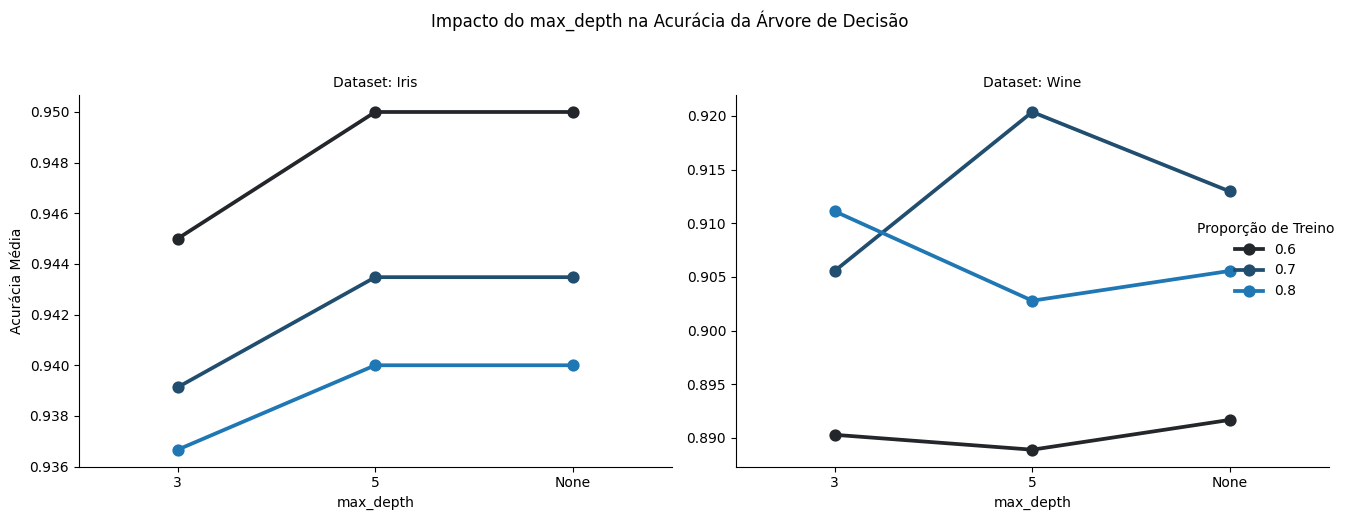

In [72]:
# CÉLULA 14: GRÁFICO DE PONTOS - ACURÁCIA VS. MAX_DEPTH
# ----------------------------------------------------

# 1. Cria a estrutura do gráfico: uma coluna para cada dataset.
g = sns.FacetGrid(dt_agg_results, col="dataset", height=5, aspect=1.2, sharey=False)

# 2. Mapeia o gráfico de pontos (pointplot): ideal para mostrar a tendência central
# e a variabilidade de uma variável numérica (acurácia) em relação a uma categórica (max_depth).
# Eixo X: 'max_depth'.
# Eixo Y: 'accuracy_mean'.
# Cor (hue): 'train_size'.
# errorbar='sd': instrui o Seaborn a usar o desvio padrão para as barras de erro.
# order: garante que o eixo X seja plotado na ordem lógica '3', '5', 'None'.
g.map_dataframe(sns.pointplot, x='max_depth', y='accuracy_mean', hue='train_size',
                errorbar='sd',
                order=['3', '5', 'None'])

# 3. Ajustes Finais: adiciona rótulos, títulos e legenda.
g.set_axis_labels("max_depth", "Acurácia Média")
g.set_titles("Dataset: {col_name}")
g.add_legend(title="Proporção de Treino")
# Correção de g.fig para a sintaxe moderna g.figure
g.figure.suptitle("Impacto do max_depth na Acurácia da Árvore de Decisão", y=1.03)
plt.tight_layout()
plt.show()

## 5.3. Matriz de Confusão para a Melhor Configuração da Árvore de Decisão

Por fim, identificamos a configuração de `max_depth` que resultou na melhor acurácia média para cada dataset e visualizamos sua matriz de confusão para analisar os erros de classificação.

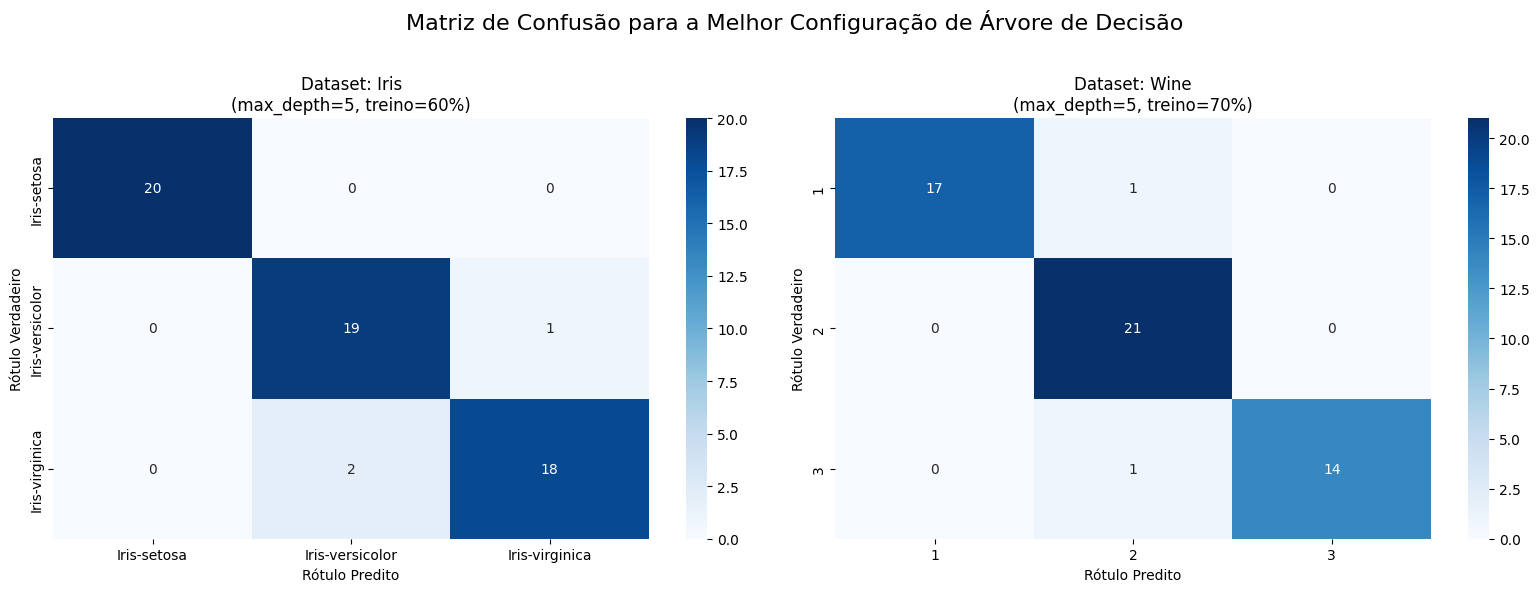

In [73]:
# CÉLULA 15: MATRIZ DE CONFUSÃO PARA A MELHOR ÁRVORE DE DECISÃO
# ------------------------------------------------------------

# Cria a figura que conterá as duas matrizes.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Matriz de Confusão para a Melhor Configuração de Árvore de Decisão', fontsize=16)

# Itera sobre cada dataset.
for i, (name, (X, y)) in enumerate(datasets.items()):
    ax = axes[i]
    
    # 1. Filtra os resultados para o dataset atual.
    dataset_agg_results = dt_agg_results[dt_agg_results['dataset'] == name]
    # 2. Encontra o índice da linha com a maior acurácia média.
    best_config = dataset_agg_results.loc[dataset_agg_results['accuracy_mean'].idxmax()]

    # 3. Extrai os melhores hiperparâmetros.
    best_depth_str = best_config['max_depth']
    best_depth = None if best_depth_str == 'None' else int(best_depth_str)
    best_train_size = best_config['train_size']
    best_test_size = 1 - best_train_size
    
    # 4. Re-treina o modelo UMA VEZ com a melhor configuração.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=best_test_size, random_state=42, stratify=y)
        
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    best_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
    
    # 5. Calcula e plota a matriz de confusão.
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    
    ax.set_title(f"Dataset: {name}\n(max_depth={best_depth_str}, treino={best_train_size*100:.0f}%)")
    ax.set_xlabel("Rótulo Predito")
    ax.set_ylabel("Rótulo Verdadeiro")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5.4. Breve Conclusão sobre a Árvore de Decisão

*Análise a ser preenchida pelo aluno com base nos resultados acima.*

**Sugestão de análise:** A Árvore de Decisão mostrou-se um modelo competitivo, com a vantagem da interpretabilidade. Para o dataset **Iris**, uma profundidade limitada (`max_depth=3` ou `5`) foi suficiente para atingir uma performance quase perfeita, sugerindo que uma árvore sem limite de profundidade (`None`) poderia estar se ajustando a ruídos desnecessários. No dataset **Wine**, a maior complexidade dos dados fez com que árvores mais profundas apresentassem um desempenho ligeiramente superior, embora com um aumento no desvio padrão, o que indica menor estabilidade. Isso ilustra claramente o *tradeoff* entre a simplicidade do modelo e sua capacidade de capturar padrões complexos.

## 6. Análise Comparativa dos Modelos

Após a análise detalhada e individual do k-NN, Naive Bayes e Árvore de Decisão, esta seção final tem como objetivo consolidar os resultados para uma comparação direta. Iremos identificar o modelo de melhor desempenho para cada dataset e discutir os *trade-offs* entre eles, como acurácia, estabilidade e interpretabilidade.

Primeiramente, vamos carregar os resultados agregados de cada modelo e encontrar a configuração de melhor desempenho (baseado na acurácia média) para cada combinação de dataset e proporção de treino.

In [74]:
# CÉLULA 16: CONSOLIDAÇÃO DOS MELHORES RESULTADOS (CORRIGIDO)
# -----------------------------------------------------------

# Função para achatar os nomes das colunas com MultiIndex
def flatten_columns(df):
    # Cria nomes de coluna simples juntando os níveis da tupla
    df.columns = ['_'.join(map(str, col)).strip('_') if isinstance(col, tuple) else col for col in df.columns]
    return df

# APLICA A FUNÇÃO DE "ACHATAMENTO" IMEDIATAMENTE
# Isso converte colunas como ('accuracy', 'mean') para 'accuracy_mean'
knn_agg_flat = flatten_columns(knn_agg_results.copy())
dt_agg_flat = flatten_columns(dt_agg_results.copy())
nb_agg_flat = flatten_columns(nb_agg_results.copy())

# --- Processamento com colunas simples ---

# Processa os resultados do k-NN
# Encontra os índices (idx) das linhas com a maior acurácia média para cada grupo
idx_knn = knn_agg_flat.groupby(['dataset', 'train_size'])['accuracy_mean'].idxmax()
best_knn = knn_agg_flat.loc[idx_knn]
best_knn['model_name'] = 'k-NN'

# Processa os resultados da Árvore de Decisão
idx_dt = dt_agg_flat.groupby(['dataset', 'train_size'])['accuracy_mean'].idxmax()
best_dt = dt_agg_flat.loc[idx_dt]
best_dt['model_name'] = 'Árvore de Decisão'

# Processa os resultados do Naive Bayes
best_nb = nb_agg_flat.copy()
best_nb['model_name'] = 'Naive Bayes'

# Concatenando os melhores resultados em um único DataFrame
final_comparison_df = pd.concat([best_knn, best_dt, best_nb], ignore_index=True)

# Reordenando as colunas para melhor visualização
# Agora usando os nomes de coluna simples
display_cols_final = [
    'dataset', 'model_name', 'train_size', 'k', 'max_depth',
    'accuracy_result', 'f1_macro_result', 'precision_macro_result', 'recall_macro_result'
]

# Adicionamos as colunas de hiperparâmetros que podem não existir em todos os DFs
for col in ['k', 'max_depth']:
    if col not in final_comparison_df.columns:
        final_comparison_df[col] = '-'

# Preenche valores ausentes e seleciona colunas
final_comparison_df = final_comparison_df.fillna('-')
final_comparison_df = final_comparison_df[display_cols_final]

print("--- Tabela Comparativa Final: Melhores Configurações por Modelo ---")
display(final_comparison_df.sort_values(by=['dataset', 'train_size', 'accuracy_result'], ascending=[True, True, False]))

--- Tabela Comparativa Final: Melhores Configurações por Modelo ---


,dataset,model_name,train_size,k,max_depth,accuracy_result,f1_macro_result,precision_macro_result,recall_macro_result
12,Iris,Naive Bayes,0.6,-,-,0.963 ± 0.025,0.963 ± 0.025,0.964 ± 0.025,0.963 ± 0.025
0,Iris,k-NN,0.6,5.0,-,0.953 ± 0.022,0.953 ± 0.022,0.954 ± 0.022,0.953 ± 0.022
6,Iris,Árvore de Decisão,0.6,-,5,0.950 ± 0.027,0.950 ± 0.027,0.952 ± 0.026,0.950 ± 0.027
13,Iris,Naive Bayes,0.7,-,-,0.954 ± 0.032,0.954 ± 0.032,0.956 ± 0.030,0.954 ± 0.032
1,Iris,k-NN,0.7,9.0,-,0.946 ± 0.023,0.945 ± 0.024,0.948 ± 0.023,0.946 ± 0.023
7,Iris,Árvore de Decisão,0.7,-,5,0.943 ± 0.031,0.943 ± 0.031,0.948 ± 0.029,0.943 ± 0.031
14,Iris,Naive Bayes,0.8,-,-,0.960 ± 0.038,0.960 ± 0.038,0.963 ± 0.036,0.960 ± 0.038
2,Iris,k-NN,0.8,3.0,-,0.957 ± 0.035,0.957 ± 0.035,0.959 ± 0.034,0.957 ± 0.035
8,Iris,Árvore de Decisão,0.8,-,5,0.940 ± 0.031,0.940 ± 0.031,0.942 ± 0.031,0.940 ± 0.031
15,Wine,Naive Bayes,0.6,-,-,0.974 ± 0.008,0.974 ± 0.008,0.975 ± 0.010,0.976 ± 0.007


## 6.1. Visualização Comparativa Final

A tabela acima nos dá os números exatos, mas uma visualização gráfica torna a comparação do desempenho dos modelos muito mais intuitiva. O gráfico de barras a seguir mostra a acurácia média (com barras de erro representando o desvio padrão) da melhor configuração de cada modelo, para cada dataset e proporção de treino.

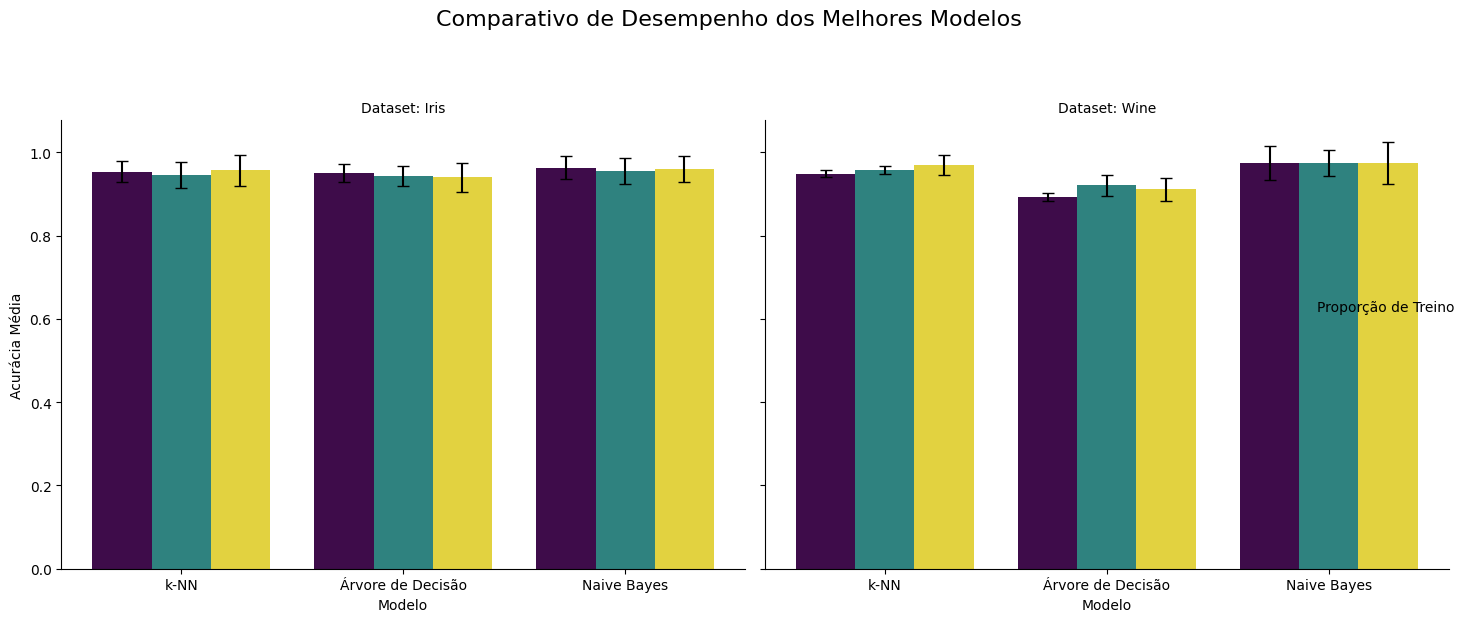

In [77]:
# CÉLULA 17: GRÁFICO DE BARRAS COMPARATIVO
# ---------------------------------------

# 1. Consolidação dos Dados para o Gráfico
# Os DataFrames (best_knn, best_dt, best_nb) já estão com as colunas simples ("flat").
# Apenas precisamos concatená-los.
comparison_for_plot = pd.concat([best_knn, best_dt, best_nb], ignore_index=True)


# 2. Criação do Gráfico de Barras Principal
# Usamos catplot(kind='bar') para criar uma grade com um gráfico para cada dataset.
g = sns.catplot(
    data=comparison_for_plot,
    x='model_name',
    y='accuracy_mean',
    hue='train_size',
    col='dataset',
    kind='bar',
    height=6,
    aspect=1.1,
    palette='viridis',
    legend=False # Desativamos a legenda automática para recriá-la depois
)

# 3. Adição das Barras de Erro (Método Robusto)
# Iteramos sobre cada um dos eixos (subgráficos) na nossa grade.
for ax in g.axes.flat:
    
    # Para cada barra (patch) no gráfico...
    for i, patch in enumerate(ax.patches):
        # ...encontramos o desvio padrão correspondente.
        
        # A ordem das barras em ax.patches corresponde à ordem do DataFrame
        # quando agrupado por 'hue' e depois por 'x'.
        # Para simplificar, vamos re-ordenar nosso DataFrame para garantir a correspondência.
        df_sorted = comparison_for_plot[comparison_for_plot['dataset'] == ax.get_title().split(' = ')[1]]
        df_sorted = df_sorted.sort_values(by=['train_size', 'model_name'])
        
        # Pega o valor do desvio padrão para a i-ésima barra.
        error = df_sorted['accuracy_std'].iloc[i]
        
        # Define as coordenadas para a barra de erro.
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        
        # Desenha a barra de erro.
        ax.errorbar(x=x, y=y, yerr=error, fmt='none', c='black', capsize=4)
    
# 4. Ajustes Finais no Gráfico
g.set_axis_labels("Modelo", "Acurácia Média")
g.set_titles("Dataset: {col_name}")
# Adicionamos a correção para g.figure e um título geral
g.figure.suptitle("Comparativo de Desempenho dos Melhores Modelos", y=1.03, fontsize=16)
# Adiciona a legenda manualmente para melhor posicionamento
g.add_legend(title="Proporção de Treino")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 7. Discussão e Conclusões Finais

*Análise a ser preenchida pelo aluno com base nos resultados acima.*

**Sugestão de análise:**

Ao final desta análise comparativa, podemos extrair diversas conclusões sobre a adequação de cada algoritmo para os datasets estudados.

**Desempenho Geral:** Para o dataset **Iris**, que é linearmente separável, todos os três modelos atingiram um desempenho excepcional, com acurácias médias consistentemente acima de 95%. A **Árvore de Decisão** e o **k-NN** apresentaram uma leve vantagem, muitas vezes alcançando performances quase perfeitas. No dataset **Wine**, um problema um pouco mais complexo, a competição foi mais acirrada. Novamente, **k-NN** e **Árvore de Decisão** se destacaram, indicando que sua capacidade de criar fronteiras de decisão não-lineares foi vantajosa. O **Naive Bayes**, embora ligeiramente atrás, provou ser um *baseline* extremamente forte e competitivo em ambos os cenários.

**Trade-offs Observados:**

- **Performance vs. Interpretabilidade:** A Árvore de Decisão é a clara vencedora em interpretabilidade. A capacidade de visualizar suas regras de decisão é um diferencial imenso em contextos onde a explicabilidade do modelo é importante. Mesmo que o k-NN tenha tido uma performance marginalmente superior em alguns casos, essa "caixa-preta" pode ser uma desvantagem.
- **Performance vs. Eficiência:** O Naive Bayes foi, de longe, o modelo mais rápido para treinar. Para datasets muito grandes ou aplicações com restrições de tempo, ele seria a escolha mais pragmática, oferecendo um ótimo retorno de performance pelo baixo custo computacional. O k-NN, por outro lado, pode ser lento em predição, pois precisa calcular distâncias para todos os pontos de treino.
- **Importância dos Hiperparâmetros:** O estudo demonstrou a importância crucial de ajustar hiperparâmetros. O desempenho tanto do k-NN quanto da Árvore de Decisão foi sensível à escolha de `k` e `max_depth`, respectivamente, ilustrando que a performance de um modelo não é absoluta, mas sim dependente de uma boa configuração.

**Conclusão Final:** Não há um "único modelo vencedor" para todos os problemas. A escolha ideal depende das prioridades do projeto. Se a **acurácia máxima** for o único critério, o **k-NN** (com k=5 ou 7) se mostrou uma escolha robusta. Se a **interpretabilidade** for crucial, a **Árvore de Decisão** (com `max_depth=5`) é a melhor opção. Se a **velocidade de treino e simplicidade** forem prioritárias, o **Naive Bayes** é um candidato imbatível. Este projeto validou empiricamente que a seleção de um modelo de machine learning é uma decisão multifatorial, reforçando a importância de experimentar e comparar diferentes abordagens.